## ÖAW AI Workshop Classification Challenge

https://www.kaggle.com/c/oeawai/overview

For this years challenge we will train a machine learning algorithm to classify instrument sounds according to their families.

We will be using an audio dataset that contains 269,776 musical notes, each with a unique pitch, timbre, and envelope. It was generated by sampling instruments from commercial sample libraries. Each sample is a four seconds, monophonic 16kHz audio snippet, referred to as notes. The notes were generated by ranging over every pitch of a standard MIDI piano (21-108) as well as five different velocities (25, 50, 75, 100, 127). The note was held for the first three seconds and allowed to decay for the final second. Some instruments are not capable of producing all 88 pitches in this range, resulting in an average of 65.4 pitches per instrument. Furthermore, the commercial sample packs occasionally contain duplicate sounds across multiple velocities, leaving an average of 4.75 unique velocities per pitch. 

In [1]:
from customdatasets import TrainDataset, TestDataset

#from trainDataset import TrainDataset
#from testDataset import TestDataset

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, transforms
from types import SimpleNamespace
import matplotlib.pyplot as plt
import csv
import librosa
import scipy as sc

import csv
import time

import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, transforms
#import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data.sampler import SubsetRandomSampler

from types import SimpleNamespace

import librosa

use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')


In [4]:
toFloat = transforms.Lambda(lambda x: x / np.iinfo(np.int16).max)

trainDataset = TrainDataset("../input/oeawai/train/kaggle-train", transform=toFloat)
print(len(trainDataset))

trainSmallDataset = TrainDataset("../input/oeawai/train-small/train-small", transform=toFloat)
print(len(trainSmallDataset))

testDataset = TestDataset("../input/oeawai/kaggle-test/kaggle-test", transform=toFloat)
print(len(testDataset))

269776
10000
4096


### Examining data

https://towardsdatascience.com/extract-features-of-music-75a3f9bc265d

#### Examining one test sample batch

In [6]:
train_loader = torch.utils.data.DataLoader(trainDataset, batch_size=64, shuffle=True)
# train_loader = torch.utils.data.DataLoader(trainSmallDataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(testDataset, batch_size=32, shuffle=False) #Shuffle should be false!

#### Examining one test sample batch

In [7]:
for samples in test_loader:
        print(samples.shape)
        print(torch.min(samples), torch.max(samples))
        print(samples)
        break

torch.Size([32, 64000])
tensor(-0.9673, dtype=torch.float64) tensor(0.9557, dtype=torch.float64)
tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-1.6907e-02,  3.4361e-01,  3.9079e-01,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 3.0519e-05,  4.8830e-04,  5.7985e-04,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  3.0519e-05,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.0987e-03,  1.3123e-03, -3.9674e-04,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]], dtype=torch.float64)


#### Examining one train sample batch

In [8]:
for samples, instrument_family_target in train_loader:
        print("samples shape: {}".format(samples.shape))
        print("instrument family shape: {}".format(instrument_family_target.shape)) 
        print("instrument family target: {}".format(instrument_family_target.data))
        print("minimum: {}".format(torch.min(samples)))
        print("maximum: {}".format(torch.max(samples)))
        print("instrument: {}".format(trainDataset.transformInstrumentsFamilyToString(instrument_family_target.data)))
        break

samples shape: torch.Size([64, 64000])
instrument family shape: torch.Size([64])
instrument family target: tensor([0, 0, 8, 0, 0, 0, 0, 3, 3, 6, 4, 4, 3, 7, 8, 4, 4, 0, 6, 5, 7, 5, 5, 5,
        5, 8, 4, 8, 6, 5, 0, 0, 6, 1, 7, 4, 3, 4, 5, 0, 5, 5, 0, 0, 7, 6, 0, 4,
        9, 6, 0, 4, 6, 0, 5, 4, 0, 9, 4, 9, 6, 8, 3, 0])
minimum: -0.9910275582140569
maximum: 0.9980468153935361
instrument: ['bass' 'bass' 'string' 'bass' 'bass' 'bass' 'bass' 'guitar' 'guitar'
 'organ' 'keyboard' 'keyboard' 'guitar' 'reed' 'string' 'keyboard'
 'keyboard' 'bass' 'organ' 'mallet' 'reed' 'mallet' 'mallet' 'mallet'
 'mallet' 'string' 'keyboard' 'string' 'organ' 'mallet' 'bass' 'bass'
 'organ' 'brass' 'reed' 'keyboard' 'guitar' 'keyboard' 'mallet' 'bass'
 'mallet' 'mallet' 'bass' 'bass' 'reed' 'organ' 'bass' 'keyboard' 'vocal'
 'organ' 'bass' 'keyboard' 'organ' 'bass' 'mallet' 'keyboard' 'bass'
 'vocal' 'keyboard' 'vocal' 'organ' 'string' 'guitar' 'bass']


#### Examining the min and max values from tensors and bulding dataframe

In [9]:
targets = []
mins = []
maxs = []
diffs = []

train_loader = torch.utils.data.DataLoader(trainDataset, batch_size=1, shuffle=True)
for samples, instrument_family_target in train_loader:
    mins.append(torch.min(samples).tolist())
    maxs.append(torch.max(samples).tolist())
    diffs.append(torch.max(samples).tolist() - torch.min(samples).tolist())
    targets.append(instrument_family_target.data.tolist()[0])

In [10]:
df_sounds = pd.DataFrame(list(zip(mins, maxs, diffs, targets)), columns = ["min", "max", "diffs", "instrument"])
df_sounds.head()

,min,max,diffs,instrument
0,-0.873287,0.946593,1.819880,4
1,-0.720878,0.834284,1.555162,7
2,-0.786981,0.743065,1.530045,5
3,-0.868770,0.849971,1.718741,0
4,-0.923673,0.946226,1.869900,4


In [11]:
df_sounds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269776 entries, 0 to 269775
Data columns (total 4 columns):
min           269776 non-null float64
max           269776 non-null float64
diffs         269776 non-null float64
instrument    269776 non-null int64
dtypes: float64(3), int64(1)
memory usage: 8.2 MB


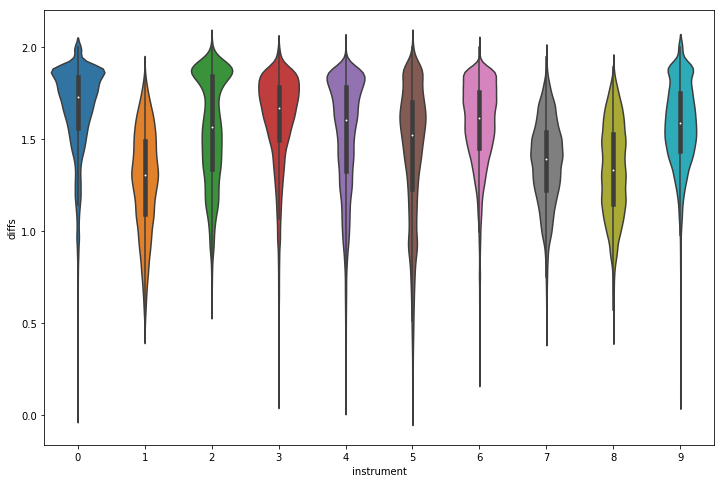

In [12]:
fig, ax = plt.subplots(figsize=(12,8))
sns.violinplot(ax=ax, x="instrument", y="diffs", data=df_sounds)
#df_sounds.groupby("instrument").mean().plot(ax=ax)

Let's define a way to transform the time-domain audio signals into time-frequency domain. It is always a good idea to plot the data to make sure the preprocessing is doing what we want it to do. 

In [13]:
def logMagStft(numpyArray, sample_rate, n_fft):
    f, t, sx = sc.signal.stft(numpyArray, fs=sample_rate, nperseg=n_fft, noverlap=n_fft//2) 
    return np.log(np.abs(sx)+np.e**-10)

Now let's measure the amount of energy in different frequency bands for all the signals. The assumption is that instruments from different families will have their energy distributed differently accross frequencies.

In [14]:
sample_rate = 16000

def computeMelspectrogram(numpyArray, sample_rate):
    S = librosa.feature.melspectrogram(y=numpyArray, sr=sample_rate, n_mels=128, fmax=8000)
    return np.log(S+1e-4)

Plotting some graphs

In [15]:
batch_size = 16
number_of_examples_to_plot = 16
n_fft = 510
sample_rate = 16000
spectrograms = np.zeros((number_of_examples_to_plot, n_fft//2+1, int(2*64000/n_fft)+2))
mfccs = np.zeros((batch_size, 128))

train_loader = data.DataLoader(trainDataset, batch_size=batch_size, shuffle=True)

for samples, instrumentsFamily in train_loader:
    for index in range(number_of_examples_to_plot):
        spectrograms[index] = logMagStft(samples[index].numpy(), sample_rate, n_fft)
        mfccs[index] = np.mean(computeMelspectrogram(samples[index].numpy(), sample_rate), axis=1)
    family = trainDataset.transformInstrumentsFamilyToString(instrumentsFamily.numpy().astype(int))
    break

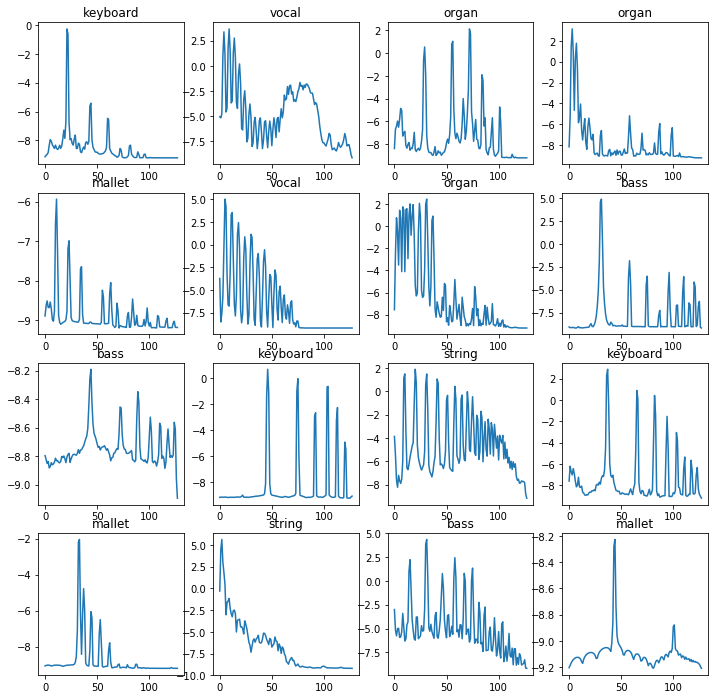

In [16]:
f, ax = plt.subplots(4, 4, figsize=(12,12))
#for i in range(batch_size):
for column in range(4):
    for line in range(4):
        #print(line+column*4)
        #plt.plot(mfccs[i])
        ax[line,column].plot(mfccs[line+column*4])
        #print(family[i])
        ax[line,column].set_title(family[line+column*4])
plt.show()

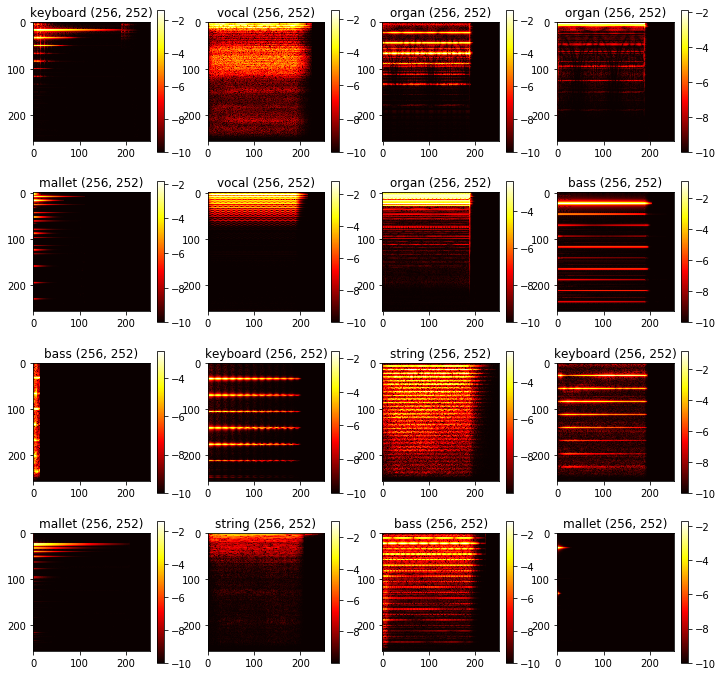

In [17]:
f, ax = plt.subplots(4, 4, figsize=(12,12))
#for i in range(batch_size):
for column in range(4):
    for line in range(4):
        ax[line,column].imshow(spectrograms[line+column*4,:,:], cmap='hot')
        title = str(family[line+column*4]) + ' ' + str(spectrograms[line+column*4].shape)
        ax[line,column].set_title(title)
        clb = ax[line,column].imshow(spectrograms[line+column*4,:,:], cmap='hot')
        plt.colorbar(clb, ax=ax[line,column])
plt.show()

### Training Classifiers

First let's create some functions to evaluate the classifiers

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def clf_eval(y_hat, y_true):
    classes=sorted(list(set(y_true)))
    clf_matrix = confusion_matrix(y_true, y_hat)
    print('Classification Report')
    print(classification_report(y_true, y_hat, target_names=classes))
    print('ROC Score: {}'.format(roc_auc_score(y_true, y_hat)))
    print('Accuracy Score: {}'.format(accuracy_score(y_true, y_hat)))
    print('Average Precision Score: {}'.format(average_precision_score(y_true, y_hat)))
    print('f1 Score: {}'.format(f1_score(y_true, y_hat)))
    plot_confusion_matrix(clf_matrix, classes=classes)
    return roc_auc_score(y_true, y_pred)

Now, let"s create train and validation sets (for cross validation)

In [19]:
batch_size = 6400
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits (cross validation):
dataset_size = len(trainDataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

#trainLoader = data.DataLoader(trainDataset, batch_size=batch_size, shuffle=True)
train_loadercv = torch.utils.data.DataLoader(trainDataset, batch_size=batch_size, sampler=train_sampler)
validation_loadercv = torch.utils.data.DataLoader(trainDataset, batch_size=batch_size, sampler=valid_sampler)

### First classifier SVM with first second of audio

* Here, we are going to use a very small trick. We know that most of our signals don't actually last four seconds, and that the complexity of SVMs is determined by the number of features and the number of training examples. So let's reduce the number of features by only using the first second of the signals to classify. Let's also keep a tab of the time it takes to train this model for future reference.

In [20]:
modelSVC = svm.SVC(gamma='auto')

start = time.time()
for samples, instrumentsFamily in train_loadercv:
    modelSVC.fit(np.array(samples.data)[:, :16000], np.array(instrumentsFamily.data))
    break # SVM is only fitted to a fixed size of data
    
print("Fitting the SVM took " + str((time.time()-start)/60) + "mins")

Fitting the SVM took 28.070378851890563mins


In [ ]:
start = time.time()

modelSVC_yhat = np.zeros(len(valid_sampler), dtype=np.int)
modelSVC_y = np.zeros(len(valid_sampler), dtype=np.int)

for index, samples in enumerate(validation_loadercv):
    modelSVC_yhat[index*batch_size:(index+1)*batch_size] = modelSVC.predict(np.array(samples[0].data)[:, :16000])
    modelSVC_y[index*batch_size:(index+1)*batch_size] = samples[1]
    
print("Classifying took " + str((time.time()-start)/60) + "mins")

In [ ]:
clf_eval(modelSVC_yhat, modelSVC_y)

Now that the model is trained, let's measure how long it takes to classify our test dataset and let's see what performance we get.

In [ ]:
start = time.time()

batch_size = 32
test_loader = data.DataLoader(testDataset, batch_size=batch_size, shuffle=False) #!!! Shuffle should be false

SVCPredictions = np.zeros(len(testDataset), dtype=np.int)

for index, samples in enumerate(test_loader):
    SVCPredictions[index*batch_size:(index+1)*batch_size] = modelSVC.predict(np.array(samples.data)[:, :16000])
    
print("Classifying took " + str((time.time()-start)/60) + "mins")

In [ ]:
familyPredictionStrings = trainDataset.transformInstrumentsFamilyToString(SVCPredictions.astype(int))

with open('SVM-submission_renato.csv', 'w', newline='') as writeFile:
    fieldnames = ['Id', 'Predicted']
    writer = csv.DictWriter(writeFile, fieldnames=fieldnames, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    writer.writeheader()
    for index in range(len(testDataset)):
        writer.writerow({'Id': index, 'Expected': familyPredictionStrings[index]})

This submission is benchmarked in the kaggle competition, it obtains a mean 0.25 F-score, which is pretty good for 10 classes with this little effort. The only 'red light' was the training time, considering that we used a very small portion of the training data.

So let's try to build a SVM machine with few features that make sense. A way to do this is to measure the amount of energy in different frequency bands for all the signals. The assumption is that instruments from different families will have their energy distributed differently accross frequencies. So now that we have some features that make more sense, let's train a SVM on these. Notice that now we are using the full duration of the signals, but still reduced them from 64k samples to 128 features.

In [ ]:
start = time.time()

modelSVC2 = svm.SVC(gamma='auto')

for samples, instrumentsFamily in train_loadercv:
    mfccs = np.zeros((len(samples), 128))
    for index, sample in enumerate(samples.data):
        mfccs[index] = np.mean(computeMelspectrogram(sample.numpy(), sample_rate), axis=1)
    modelSVC2.fit(mfccs, instrumentsFamily.numpy())
    break # SVM is only fitted to a fixed size of data
    
print("Fitting the SVM took " + str((time.time()-start)/60) + "mins")

In [ ]:
start = time.time()

batch_size = 32
modelSVC2_yhat = np.zeros(len(valid_sampler), dtype=np.int)
modelSVC2_y = np.zeros(len(valid_sampler), dtype=np.int)

for index, samples in enumerate(validation_loadercv):
    modelSVC2_yhat[index*batch_size:(index+1)*batch_size] = modelSVC2.predict(np.array(samples[0].data)[:, :16000])
    modelSVC2_y[index*batch_size:(index+1)*batch_size] = samples[1]
    
print("Classifying took " + str((time.time()-start)/60) + "mins")

In [ ]:
clf_eval(modelSVC2_yhat, modelSVC2_y)

### Neural Networks

In [ ]:
# Hyperparameters
args = SimpleNamespace(batch_size=64, 
                       test_batch_size=32, 
                       epochs=3, lr=0.01, 
                       momentum=0.5, 
                       seed=1, 
                       log_interval=200)

torch.manual_seed(args.seed)

In [ ]:
# NN architecture (three conv and two fully connected layers)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.first_conv = nn.Conv2d(1, 20, 5, 1)
        self.second_conv = nn.Conv2d(20, 50, 5, 2)
        self.third_conv = nn.Conv2d(50, 50, 5, 2)
        self.fc1 = nn.Linear(50*6*6, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        n_fft = 510
    
        spectrograms = np.zeros((len(x), n_fft//2+1, int(2*64000/n_fft)+2))
        for index, audio in enumerate(x.cpu().numpy()):
            spectrograms[index] = logMagStft(audio, 16000, n_fft)
        
        x = torch.from_numpy(spectrograms[:, np.newaxis, :, :]).to(device).float()
        
        # x.size is (batch_size, 1, 256, 252)
        x = F.relu(self.first_conv(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.second_conv(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.third_conv(x))
        x = F.max_pool2d(x, 2, 2)
        # x.size is (batch_size, 50, 6, 6)
        x = x.view(-1, 6*6*50)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
# This function trains the model for one epoch
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [ ]:
# This function evaluates the model on the test data
def test(args, model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        familyPredictions = np.zeros(len(test_loader.dataset), dtype=np.int)
        for index, samples in enumerate(test_loader):
            samples = samples.to(device)
            familyPredictions[index*len(samples):(index+1)*len(samples)] = model(samples).max(1)[1].cpu() # get the index of the max log-probability
    
    familyPredictionStrings = trainDataset.transformInstrumentsFamilyToString(familyPredictions.astype(int))

    with open('NN-submission-' +str(epoch)+'.csv', 'w', newline='') as writeFile:
        fieldnames = ['Id', 'Expected']
        writer = csv.DictWriter(writeFile, fieldnames=fieldnames, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writeheader()
        for index in range(len(testDataset)):
            writer.writerow({'Id': index, 'Expected': familyPredictionStrings[index]})
    print('saved predictions')

In [ ]:
# Main
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=args.lr, 
                      momentum=args.momentum)

for epoch in range(1, args.epochs + 1):
    train(args, model, device, train_loader, optimizer, epoch)
    test(args, model, device, test_loader, epoch)
